## MIIA-4203 MODELOS AVANZADOS PARA ANÁLISIS DE DATOS II


# Red neuronal sencilla

## Actividad 3

### Profesor: Camilo Franco (c.franco31@uniandes.edu.co)


En este cuadernos continuaremos con nuestra aproximación a las redes neuronales de la mano con la clasificación de imagenes. Generalizaremos nuestra implementación de un perceptrón para que la red considere una agrupación de neuronas. Como se demuestra en "Multilayer Feedforward Networks are Universal Approximators" (K. Hornik, M. Stinchcombe & H. White, 1989, *Neural Networks* Vol. 2, 359-366), una red neuronal sencilla (con una única capa escondida y con un número suficiente de neuronas) es un tipo de *aproximador universal*, capaz de aproximar cierto tipo de funciones a cualquier nivel de precisión. 

## Actividad en grupos
### Nombres:

**Daniel Augusto Leon Moreno**

**David Tavera Sanchez**

**Instrucciones:** Por favor escriba los nombres de los integrantes de su grupo. Esta actividad debe ser entregada a más tardar dentro de 8 días, con la respuesta para los ejercicios y preguntas en cada numeral.



## 1. Construcción de una red neuronal sencilla

En esta actividad podremos ver la diferencia de un modelo con una sola neurona (replicando la regresión logística en cuanto su función de activación sea la *sigmoide*) que vimos en la actividad anterior,  y uno con múltiples neuronas dentro de una sola capa escondida. 

De esta manera, implementaremos una red neuronal con una capa escondida para un problema de clasificación binario. Usaremos múltiples neuronas con una función de activación no-lineal, como por ejemplo la función de tangente hiperbólica (tanh), y calcularemos la función de pérdida de entropía cruzada. Finalmente implementaremos la propagación hacia delante y hacia atrás con el fin de estimar los parámetros del modelo iterativamente por medio del algoritmo de descenso en la dirección del gradiente (GD).



A continuación llamamos los paquetes que vamos a utilizar:

In [1]:
# Importación de paquetes
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
import sklearn.linear_model

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

%matplotlib inline

## 2 - Conjunto de datos ##

Primero, cargamos el conjunto de datos sobre el que se va a trabajar. El siguiente código va a cargar un conjunto de datos `X` e `Y` donde `Y`es una variable binaria.

In [2]:
def datos_nl(semilla,m):
    N = int(m/2) # numero de puntos por clase
    D = 2 # dimensionalidad
    X = np.zeros((m,D)) # matriz de datos donde cada fila es un unico ejemplo
    Y = np.zeros((m,1), dtype='uint8') # vector de etiquetas (0 para rojo, y 1 para azul)
    a = 4 # trazado maximo de la flor

    for j in range(2):
        ix = range(N*j,N*(j+1))
        t = np.linspace(j*3.12,(j+1)*3.12,N) + np.random.randn(N)*0.2 # theta
        r = a*np.sin(4*t) + np.random.randn(N)*0.2 # radio
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        Y[ix] = j
        
    X = X.T
    Y = Y.T

    return X, Y

Visualizamos los datos mediante matplotlib. Los datos tienen puntos rojos (y=0) y azules (y=1). El objetivo es el de constuir un modelo que se ajuste a estos datos. 

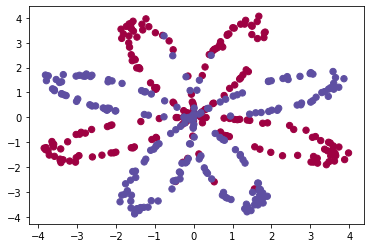

In [3]:
semilla=np.random.seed(66)
m = 400 # numero de ejemplos
X, Y = datos_nl(semilla,m)

# Visualizamos los datos:
plt.scatter(X[0, :], X[1, :], c=Y[0,:], s=40, cmap=plt.cm.Spectral)

Tenemos una matriz $X$ con los patrones ($X_1$, $X_2$), y un vector $Y$ con las etiquetas ($0=$*rojo*, $1=$*azul*).

Examinemos los datos a continuación.

### Ejercicio 2.1

Cuántos ejemplos de entrenamiento tenemos? O cuáles son las dimensiones (`shape`) de `X` e `Y`? 

**Ayuda**: Recuerde cómo obtener la forma de un arreglo numpy [(ayuda)](https://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.shape.html)

**Respuesta** Hay 400 ejemplos de entrenamiento

In [4]:
dim_X = X.shape
dim_Y = Y.shape
m = X.shape[1]         # tamaño del conjunto de entrenamiento

print ('Las dimensiones de X son: ' + str(dim_X))
print ('Las dimensiones de Y son: ' + str(dim_Y))
print ('Hay m = %d ejemplos de entrenamiento' % (m))

Las dimensiones de X son: (2, 400)
Las dimensiones de Y son: (1, 400)
Hay m = 400 ejemplos de entrenamiento


**Salida esperada**: 
       
<table style="width:40%">
<tr>
<td>Dimensiones de X</td>
<td> (2, 400) </td> 
</tr>
<tr>
<td>Dimensiones de Y</td>
<td>(1, 400) </td> 
</tr>
<tr>
<td>m</td>
<td> 400 </td> 
</tr>
</table>

## 3 - Regresión Logística

Antes de contruir una red neuronal, primero estudiemos cómo se comporta la regresión logística con este problema. Podemos utilizar las funciones de sklearn para hacerlo. Ejecute el siguiente código para entrenar un clasificador de regresión logística sobre el conjunto de datos.

In [5]:
# Entrene el clasificador logístico
clf = sklearn.linear_model.LogisticRegressionCV(cv=5)
Y2=np.squeeze(Y)
clf.fit(X.T, Y2)

LogisticRegressionCV(cv=5)

Ahora se puede graficar la frontera de decisión para este modelo de acuerdo con la siguiente funcion: 

In [6]:
def plot_frontera_decision(model, X, y):
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    # grilla de puntos a una distancia h entre ellos
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # predice el valor de la funcion para toda la grilla
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # grafica el contorno y los ejemplos de entrenamiento
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y, cmap=plt.cm.Spectral)
    

Podemos ver la frontera de decisión mediante el siguiente código:

Exactitud de la regresión logística: 49 % (porcentaje de puntos correctamente etiquetados)


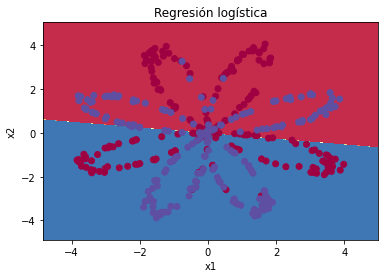

In [7]:
# Grafique la frontera de decisión para la regresión logística
plot_frontera_decision(lambda x: clf.predict(x), X, Y2)
plt.title("Regresión logística")

# Exactitud
LR_predictions = clf.predict(X.T)
print ('Exactitud de la regresión logística: %d ' % float((np.dot(Y,LR_predictions) + np.dot(1-Y,1-LR_predictions))/float(Y.size)*100) +
       '% ' + "(porcentaje de puntos correctamente etiquetados)")

**Salida esperada**: 

<table style="width:20%">
<tr>
<td> 
Exactitud
</td>
<td> 49% </td> 
</tr>
  
</table>

**Discusión**: como se esperaba, el conjunto de datos no es linealmente separable. Por esto, la regresión logística no logra un buen desempeño. Pero la red neuronal sí que debería lograr un mejor desempeño.  


## 4 - Modelo de red neuronal

La regresión logística no logró buenos resultados sobre el conjunto de datos. Por lo tanto, ahora vamos a entrenar una red neuronal con una sola capa escondida.

**Formulación matemática**:

Para un ejemplo $x^{(i)}$:

$$z^{[1] (i)} =  W^{[1]} x^{(i)} + b^{[1]}\tag{1}$$ 

$$a^{[1] (i)} = \tanh(z^{[1] (i)})\tag{2}$$

$$z^{[2] (i)} = W^{[2]} a^{[1] (i)} + b^{[2]}\tag{3}$$

$$\hat{y}^{(i)} = a^{[2] (i)} = \sigma(z^{ [2] (i)})\tag{4}$$

$$y^{(i)}_{prediccion} = \begin{cases} 1 & \mbox{si } a^{[2](i)} > 0.5 \\ 0 & \mbox{en caso contrario (e.c.c.) } \end{cases}\tag{5}$$

Dadas las predicciones sobre todos los ejemplos, computamos el coste $L$ de acuerdo con la función de entropía cruzada: 
$$L = - \frac{1}{m} \sum\limits_{i = 0}^{m} \large\left(\small y^{(i)}\log\left(a^{[2] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[2] (i)}\right)  \large  \right) \small \tag{6}$$

**Recuerde**: La metodología general para construir una red neuronal:
1. Definir una estructura de red neuronal ( Tamaño del input,  # de neuronas/unidades de decisión escondidas)
2. Inicializar los parámetros del modelo
3. Bucle:
   - Implementar propagación hacia delante
   - Computar la pérdida
   - Implementar la propagación hacia atrás mediante los gradientes
   - Actualizar los parámetros (Descenso en la dirección del gradiente: GD)

Se pueden construir funciones auxiliares para computar los pasos 1-3 y luego fusionarlas en una función global llamada `modelo_red()`. Una vez construida `modelo_red()` y habiendo aprendido los parámetros adecuados, se pueden hacer predicciones sobre nuevos datos.

### 4.1 - Definiendo la estructura de la red neuronal ####

### Ejercicio 4.1
Defina tres variables:
    - n_x: tamaño de la capa de entrada
    - n_h: tamaño de la capa oculta 
    - n_y: tamaño de la capa de salida

Podemos utilizar las dimensiones de $X$ e $Y$ para encontrar $n_x$ y $n_y$. 

In [8]:
def dim_capas(X, Y, num_neuronas):
    """
    Input:
    X: conjunto de datos de entrada, con dimensines (tamaño del input, número de ejemplos)
    Y: etiquetas (tamaño del output, número de ejemplos)
    Output:
    n_x: tamaño de la capa de entrada
    n_h: tamaño de la capa escondida
    n_y: tamaño de la capa de salida
    """
    n_x = X.shape[0]      # tamaño de la capa de entrada
    n_h = num_neuronas    # número de neuronas en la capa escondida
    n_y = Y.shape[0]      # tamaño de la acapa de salida

    return (n_x, n_h, n_y)

In [9]:
num_neuronas = 4

(n_x, n_h, n_y) = dim_capas(X, Y, num_neuronas)
print("El tamaño de la capa de entrada es: n_x = " + str(n_x))
print("El tamaño de la capa de escondida es: n_h = " + str(n_h))
print("El tamaño de la capa de salida es: n_y = " + str(n_y))

El tamaño de la capa de entrada es: n_x = 2
El tamaño de la capa de escondida es: n_h = 4
El tamaño de la capa de salida es: n_y = 1


**Salida esperada**:  tenga en cuenta que esta comprobación es sólo para verificar que la función que ha programado es correcta. En la implemenatción de la red utilizaremos otras dimensiones.


<table style="width:20%">
<tr>
<td>n_x</td>
<td> 2 </td> 
</tr>
<tr>
<td>n_h</td>
<td> 4 </td> 
</tr>
<tr>
<td>n_y</td>
<td> 1 </td> 
</tr>
</table>

### 4.2 - Inicialización de los parámetros del modelo 

### Ejercicio 4.2

Ahora vamos a implementar la función `param_I()`.

**Paso a paso**:
- Debemos asegurarnos de que las dimensiones de los parámetros sean las correctas. 
- Inicializamos los pesos con valores aleatorios. 
    - Usamos `np.random.randn(a,b) * 0.01` para esta inicialización aleatoria de una matriz de dimensiones (a,b).
- Inicializamos los vectores de sesgo con ceros. 
    - Usamos `np.zeros((a,b))` para la inicialización con ceros de la matriz de tamaño (a,b).

In [10]:

def param_I(n_x, n_h, n_y, semilla):
    """
    Input:
    n_x: tamaño de la capa de entrada
    n_h: tamaño de la capa escondida
    n_y: tamaño de la capa de salida
    Output:
    param: diccionario python con los parámetros:
            W1: matriz de pesos con dimensiones (n_h, n_x)
            b1: matriz de sesgos con dimensiones (n_h, 1)
            W2: matriz de pesos con dimensiones (n_y, n_h)
            b2: matriz de sesgos con dimensiones (n_y, 1)
    """
    np.random.seed(semilla)
    
    W1 = np.random.randn(n_h,n_x) * 0.01
    b1 = np.zeros((n_h,1))
    W2 = np.random.randn(n_y,n_h) * 0.01
    b2 = np.zeros((n_y,1))
    
    assert (W1.shape == (n_h, n_x))
    assert (b1.shape == (n_h, 1))
    assert (W2.shape == (n_y, n_h))
    assert (b2.shape == (n_y, 1))
    
    param = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return param

In [11]:
param = param_I(n_x, n_h, n_y, semilla=2)
print("W1 = " + str(param["W1"]))
print("b1 = " + str(param["b1"]))
print("W2 = " + str(param["W2"]))
print("b2 = " + str(param["b2"]))

W1 = [[-0.00416758 -0.00056267]
 [-0.02136196  0.01640271]
 [-0.01793436 -0.00841747]
 [ 0.00502881 -0.01245288]]
b1 = [[0.]
 [0.]
 [0.]
 [0.]]
W2 = [[-0.01057952 -0.00909008  0.00551454  0.02292208]]
b2 = [[0.]]


**Salida esperada**: 

<table style="width:80%">
<tr>
<td>W</td>
<td> [[-0.00416758 -0.00056267]
 [-0.02136196  0.01640271]
 [-0.01793436 -0.00841747]
 [ 0.00502881 -0.01245288]] </td> 
</tr>
<tr>
<td>b1</td>
<td> [[0.]
 [0.]
 [0.]
 [0.]] </td> 
<tr>
<td>W2</td>
<td> [[-0.01057952 -0.00909008  0.00551454  0.02292208]] </td> 
</tr>
<tr>
<td>b2</td>
<td> [[ 0.]] </td> 
</tr>
</table>

### 4.3 - El bucle ####

### Propagación hacia delante

### Ejercicio 4.3.1 
Implemente la propagación hacia delante `propagacion()`.

Ayuda: Puede usar la función `sigmoide()` que ya hemos programado anteriormente y la función `np.tanh()` (es parte de la biblioteca numpy).

- Los pasos que debe implementar son:
  1. Recupere cada parámetro del diccionario "param" (que es la salida de `param_I()`), utilizando `param[".."]`.
  2. Implemente la propagación hacia delante. Compute $Z^{[1]}, A^{[1]}, Z^{[2]}$ y $A^{[2]}$ (el vector de todas sus predicciones sobre todos los ejemplos del conjunto de entrenamiento).
  
- Los valores necesarios para calcular la retro-propagación son guardados en "`memo`". Esta `memo` será proporcionada como entrada a la función de retro-propagación.

In [12]:
def sigmoide(x):

    s = 1/(1+np.exp(-x))
    return s


In [13]:
def propagacion(X, param):
    """
    Input: 
    X: datos de entrada de tamaño (n_x, m)
    param: diccionario python con los parameters (salida de la funcion de inicialización)
    Output:
    A2: la salida de la función sigmoide de la segunda activación
    memo: un diccionario conteniendo "Z1", "A1", "Z2" y "A2"
    """
    # Recupera cada parámetro del diccionario "param"
    W1 = param["W1"]
    b1 = param["b1"]
    W2 = param["W2"]
    b2 = param["b2"]
    
    # Implemente la propagación hacia delante para calcular las probabilidades A2 
    Z1 = np.dot(W1,X)+b1
    A1 = np.tanh(Z1)
    Z2 = np.dot(W2,A1)+b2
    A2 = sigmoide(Z2)
    
    assert(A2.shape == (1, X.shape[1]))
    
    memo = {"Z1": Z1,
             "A1": A1,
             "Z2": Z2,
             "A2": A2}
    
    return A2, memo

In [14]:
A2, memo = propagacion(X, param)

print(np.mean(memo['Z1']) ,np.mean(memo['A1']),np.mean(memo['Z2']),np.mean(memo['A2']))

0.0003756589777913734 0.00037584732210443054 2.533841178721172e-08 0.5000000063347811


**Salida esperada**: 
<table style="width:90%">
<tr>
<td> 0.0003756589777913734 0.00037584732210443054 2.533841178721172e-08 0.5000000063347811
</td> 
</tr>
</table>

### Función de pérdida

Ahora que ya hemos calculado $A^{[2]}$ (en la variable Python "`A2`"), con los valores  $a^{[2](i)}$ para cada ejemplo ($i$) podemos computar la función de coste:

$$L = - \frac{1}{m} \sum\limits_{i = 0}^{m} \large{(} \small y^{(i)}\log\left(a^{[2] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[2] (i)}\right) \large{)} \small\tag{7}$$

### Ejercicio 4.3.2
Implemente la función `perdida()` para calcular el valor de la pérdida $L$.


*Ayuda:*
Por ejemplo, la expresión $$- \sum\limits_{i=0}^{m}  y^{(i)}\log(a^{[2](i)})$$ se puede implementar de la siguiente manera:
```python
logprobs = np.multiply(np.log(A2),Y)
coste = - np.sum(logprobs)                
```
Puede usar tanto `np.multiply()` y luego `np.sum()`, como también `np.dot()`.


In [15]:

def perdida(A2, Y):
    """
    Computa la función de pérdida de entropía cruzada de la ecuación
    Input:
    A2: la salida de la función sigmoide para la segunda activación, de tamaño (1, numero de ejemplos)
    Y: vector de etiquetas de tamaño (1, numero de ejemplos)
    param: diccionario python con los parametros W1, b1, W2 and b2
    Ouput:
    coste: coste de entropía cruzada 
    """
    
    m = Y.shape[1]         # numero de ejemplos

    # Coste de entropía cruzada
    coste = -1/m*np.sum(Y*np.log(A2)+(1-Y)*np.log(1-A2))                        # no hay necesidad de usar un bucle!
    
    coste = np.squeeze(coste)      # se asegura que el coste sea de la dimension esperada, e.g. un [[99]] lo torna en 99 
    assert(isinstance(coste, float))
    
    return coste

In [16]:
print("coste = " + str(perdida(A2, Y)))

coste = 0.6930274319338173


**Salida esperada**: 
<table style="width:40%">
<tr>
<td>coste</td>
<td> 0.6930274319338173 </td> 
</tr>
</table>

### Retro-propagación

Ahora vamos a implementar el concepto más más importante de una red neuronal. Utilizando la memoria (`memo`) computada en la propagacion hacia delante, podemos implementar la propagación hacia atrás. Este paso nos permitirá actualizar la estimación de nuestros parámetros, es decir, paso a paso ir *aprendiendo* la frontera de decisión de acuerdo con los ejemplos de entrenamiento.

### Ejercicio 4.3.3

Implemente la función `retro()` para la **retro-propagación del error**

La retro-propagación suele ser la parte más difícil para la construcción de una red neuronal. Recordemos lo que es la retro-propagación. Se deben utilizar las seis ecuaciones siguientes


$\frac{\partial L }{ \partial z_{2}^{(i)} } = \frac{1}{m} (a^{[2](i)} - y^{(i)})\tag{8}$

$\frac{\partial L }{ \partial W_2 } = \frac{\partial L }{ \partial z_{2}^{(i)} } a^{[1] (i) T} \tag{9}$

$\frac{\partial L }{ \partial b_2 } = \sum_i{\frac{\partial L }{ \partial z_{2}^{(i)}}}\tag{10}$

$\frac{\partial L }{ \partial z_{1}^{(i)} } =  W_2^T \frac{\partial L }{ \partial z_{2}^{(i)} } * ( 1 - a^{[1] (i) 2})\tag{11} $

$\frac{\partial L}{ \partial W_1 } = \frac{\partial L }{ \partial z_{1}^{(i)} }  X^T \tag{12}$

$\frac{\partial L }{ \partial b_1 } = \sum_i{\frac{\partial L }{ \partial z_{1}^{(i)}}} \tag{13}$

- Nótese que $*$ denota multiplicación por cada elemento.
- En el código utilizamos la siguiente notación:
    - dW1 = $\frac{\partial L }{ \partial W_1 }$
    - db1 = $\frac{\partial L }{ \partial b_1 }$
    - dW2 = $\frac{\partial L }{ \partial W_2 }$
    - db2 = $\frac{\partial L }{ \partial b_2 }$
    


- Ayuda:
    - Para computar dZ1 se debe calcular primero $g^{[1]'}(Z^{[1]})$. Como $g^{[1]}(.)$ es la función de activación tanh, si $a = g^{[1]}(z)$ entonces $g^{[1]'}(z) = 1-a^2$. Para mayores detalles puede ver: https://socratic.org/questions/what-is-the-derivative-of-tanh-x
    - Entonces puede calcular 
    $g^{[1]'}(Z^{[1]})$ utilizando `(1 - np.power(A1, 2))`.
    - Tenga en cuenta las dimensiones correctas para la implementación de la propagación hacia atrás en el cálculo de $db$. Por ejemplo, para $db1$, si quiere sumar las columnas (filas), $axis=1$ ($axis=0$).
    - También tenga en cuenta que las dimensiones se pueden manetener fijas mediante el argumento $keepdims=True$.

In [17]:
def retro(param, memo, X, Y):
    """
    Implementa la retro-propagación del error
    Input:
    param: diccionario python con los parameteros 
    memo: un diccionario con "Z1", "A1", "Z2" y "A2".
    X: datos de entrada  
    Y: vector de etiquetas 
    Output:
    grads: diccionario python con los gradientes de los diferentes parametros
    """
    m = X.shape[1]     # numero de ejemplos en X
    
    # Recuperamos los pesos W1 y W2 del diccionario "param".
    W1 = param['W1']
    W2 = param['W2'] 
        
    # Recuperamos A1 y A2 del diccionario "memo".
    A1 = memo['A1']
    A2 = memo['A2']
    
    # Retro-propagacion: calcula dW1, db1, dW2, db2. 
    dZ2 = np.dot((1/m),(A2-Y))
    dW2 = np.dot(dZ2,A1.T) #falta
    db2 = np.sum(dZ2,axis=1,keepdims=True)
    dZ1 = W2.T*dZ2*(1-np.power(A1,2))
    dW1 = np.dot(dZ1,X.T)
    db1 = np.sum(dZ1,axis=1,keepdims=True)
    
    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2}
    
    return grads

In [18]:
grads = retro(param, memo, X, Y2)
print ("dW1 = "+ str(grads["dW1"]))
print ("db1 = "+ str(grads["db1"]))
print ("dW2 = "+ str(grads["dW2"]))
print ("db2 = "+ str(grads["db2"]))

dW1 = [[-0.00022872 -0.00278702]
 [-0.00018844 -0.00238845]
 [ 0.00012072  0.00145306]
 [ 0.00049226  0.00602335]]
db1 = [[ 1.02430069e-08]
 [ 2.36592378e-07]
 [-1.30321698e-07]
 [-1.50321903e-07]]
dW2 = [[-0.00023831  0.00386166 -0.00260686 -0.00316916]]
db2 = [[6.33478109e-09]]


**Salida esperada**: 

<table style="width:80%">
<tr>
<td>dW1</td>
<td> [[-0.00022872 -0.00278702]
 [-0.00018844 -0.00238845]
 [ 0.00012072  0.00145306]
 [ 0.00049226  0.00602335]] </td> 
</tr>
<tr>
<td>db1</td>
<td>  [[ 1.02430069e-08]
 [ 2.36592378e-07]
 [-1.30321698e-07]
 [-1.50321903e-07]] </td> 
</tr>
<tr>
<td>dW2</td>
<td> [[-0.00023831  0.00386166 -0.00260686 -0.00316916]] </td> 
</tr>
<tr>
<td>db2</td>
<td> [[6.33478109e-09]] </td> 
</tr>
</table>  

### Actualización de parámetros

### Ejercicio 4.3.4

Implementamos la regla de actualización de nuestros estimadores dentro del GD. Usamos el método GD. Debe usar (dW1, db1, dW2, db2) para actualizar (W1, b1, W2, b2).


*Ayuda:* La regla general del GD consiste en definir $ \hat \theta_{nuevo} = \hat \theta_{viejo} - \alpha \frac{\partial L }{ \partial \hat \theta_{viejo} }$ donde $\alpha$ es la tasa de aprendizaje y $\theta$ representa un parámetro.




In [19]:

def rev_param(param, grads, tasa):
    """
    Actualice los parametros usando la regla de actualización del GD
    Input:
    param: diccionario python con los parametros 
    grads: diccionario python con los gradientes 
    Output:
    param: diccionario python con los parametros actualizados 
    """
    # Los parametros del diccionario "param"
    W1 = param["W1"]
    b1 = param["b1"]
    W2 = param["W2"]
    b2 = param["b2"]
    
    # Los gradientes del diccionario "grads"
    dW1 = grads["dW1"]
    db1 = grads["db1"]
    dW2 = grads["dW2"]
    db2 = grads["db2"]
    
    # Regla de actualización para cada parametro
    W1 = W1-tasa*dW1
    b1 = b1-tasa*db1
    W2 = W2-tasa*dW2
    b2 = b2-tasa*db2
    
    param = {"W1": W1, "b1": b1, "W2": W2, "b2": b2}
    
    return param

In [20]:
param = rev_param(param, grads, tasa=1.2)

print("W1 = " + str(param["W1"]))
print("b1 = " + str(param["b1"]))
print("W2 = " + str(param["W2"]))
print("b2 = " + str(param["b2"]))

W1 = [[-0.00389312  0.00278176]
 [-0.02113583  0.01926884]
 [-0.01807922 -0.01016114]
 [ 0.0044381  -0.0196809 ]]
b1 = [[-1.22916083e-08]
 [-2.83910854e-07]
 [ 1.56386037e-07]
 [ 1.80386284e-07]]
W2 = [[-0.01029355 -0.01372407  0.00864277  0.02672507]]
b2 = [[-7.60173731e-09]]


**Salida esperada**: 

<table style="width:80%">
<tr>
<td>W1</td>
<td> [[-0.00389312  0.00278176]
 [-0.02113583  0.01926884]
 [-0.01807922 -0.01016114]
 [ 0.0044381  -0.0196809 ]]</td> 
</tr>
<tr>
<td>b1</td>
<td> [[-1.22916083e-08]
 [-2.83910854e-07]
 [ 1.56386037e-07]
 [ 1.80386284e-07]]</td> 
</tr>
<tr>
<td>W2</td>
<td> [[-0.01029355 -0.01372407  0.00864277  0.02672507]] </td> 
</tr>
<tr>
<td>b2</td>
<td> [[-7.60173731e-09]] </td> 
</tr>
</table>  

### 4.4 - Combinacion de funciones

Ahora integramos las partes 4.1, 4.2 y 4.3 en modelo_red()

### Ejercicio
Construya su modelo de red neuronal en `modelo_red()`.

El modelo de la red debe usar las funciones previamente construidas en el orden correcto.

In [21]:
def modelo_red(X, Y, n_h, num_iter, tasa, print_c, semilla):
    """
    Input:
    X: datos de entrada 
    Y: vector de etiquetas  
    n_h: tamaño de la capa escondida
    num_iter: numero de iteraciones del bucle del GD
    tasa: tasa de aprendizaje
    print_c: si "True", muestra el coste cada 1000 iteraciones
    semilla: semilla aleatoria
    Output:
    param: parametros aprendidos para el modelo final. Se utilizan para la predicción
    """

    n_x = X.shape[0]
    n_y = Y.shape[0]
    
    # Inicializa los parámetros y carga W1, b1, W2, b2. 
    # Inputs: "n_x, n_h, n_y, semilla". Outputs = "W1, b1, W2, b2, parametros".
    param = param_I(n_x, n_h, n_y, semilla)
    W1 = param["W1"]
    b1 = param["b1"]
    W2 = param["W2"]
    b2 = param["b2"]
    
    # Bucle (GD)
    for i in range(0, num_iter):
         
        # Propagación hacia delante. 
        # Inputs: "X, param". Outputs: "A2, memo".
        A2, memo = propagacion(X, param)
        
        # Función de coste. 
        # Inputs: "A2, Y, param". Outputs: "coste".
        coste = perdida(A2, Y)
 
        # Retro-propagacion. 
        # Inputs: "param, memo, X, Y". Outputs: "grads".
        grads = retro(param, memo, X, Y)
 
        # Actualizacion de parametros por GD. 
        # Inputs: "param, grads, tasa". Outputs: "param".
        param = rev_param(param, grads, tasa=1.2)
              
        # Muestre el coste cada 1000 iteraciones
        if print_c and i % 1000 == 0:
            print ("Coste tras la iteración %i: %f" %(i, coste))

    return param

In [22]:
param = modelo_red(X, Y, n_h=4, num_iter=10000, tasa=2.5, print_c=True, semilla=0)
print("W1 = " + str(param["W1"]))
print("b1 = " + str(param["b1"]))
print("W2 = " + str(param["W2"]))
print("b2 = " + str(param["b2"]))

Coste tras la iteración 0: 0.693165
Coste tras la iteración 1000: 0.223759
Coste tras la iteración 2000: 0.216800
Coste tras la iteración 3000: 0.211363
Coste tras la iteración 4000: 0.207004
Coste tras la iteración 5000: 0.204526
Coste tras la iteración 6000: 0.203150
Coste tras la iteración 7000: 0.202390
Coste tras la iteración 8000: 0.201942
Coste tras la iteración 9000: 0.201646
W1 = [[ -0.15664393 -13.65680021]
 [  6.78438866   8.00026754]
 [  5.3477068   -6.30944193]
 [ -1.66714442   3.95358646]]
b1 = [[-0.02172706]
 [ 0.08775515]
 [ 0.33343804]
 [-1.5503873 ]]
W2 = [[-8.97335023 -7.21497721  6.18254156  2.07938296]]
b2 = [[-0.02157562]]


**Salida esperada**: 

<table style="width:90%">
<tr> 
<td>  coste tras la iteracion 1000
</td>
<td> 0.212237
</td>
</tr>
<tr> 
<td> 
<center> $\vdots$ </center>
</td>
<td> 
<center> $\vdots$ </center>
</td>
</tr>
<tr>
<td>W1</td>
<td> [[ 2.03147148 -5.88139449]
 [ 8.20917502  9.54149218]
 [ 6.29283248 -7.35003994]
 [ 0.18185045 16.37644482]]</td> 
</tr>
<tr>
<td>b1</td>
<td> [[ 2.21377078]
 [ 0.11075722]
 [ 0.28745752]
 [-0.01307749]] </td> 
</tr>
<tr>
<td>W2</td>
<td> [[-1.44301402 -7.0813084   5.6022717   8.89984852]] </td> 
</tr>
<tr>
<td>b2</td>
<td> [[-0.03814504]] </td> 
</tr>
</table>  

### 4.5 Predicciones

Ahora que tenemos nuestro código completo para la implementación de una red de red neuronal sencilla, podemos utilizarlo para predecir la clase de nuevas observaciones. Pero antes debemos convertir las probabilidades de nuestro modelo en predicciones nítidas para asignar la clase. 

### Ejercicio 4.5.1
Especifique la funcion pred(), la cual haga uso de la propagacion hacia delante para predecir la clase.

La función que queremos implementar:

$y_{prediccion} = \begin{cases}
      1 & \text{si }\ activacion > 0.5 \\
      0 & \text{$e.c.c.$}
    \end{cases}$  

    
Como un ejemplo, si quiere fijar las entradas de una matriz de X a 0 y 1 basados en un $umbral$, se puede hacer de la siguiente manera: $$X_{nuevo} = (X > umbral)$$

In [23]:

def pred(param, X):
    """
    Usando las estimaciones de los parámetros, predice una clase para cada ejemplo de X
    Input:
    param: diccionario python con los parametros 
    X: datos de entrada de tamaño (n_x, m)
    Output:
    prediccion: vector de predicciones para el modelo (rojo: 0 / azul: 1)
    """
    
    # Compute las probabilidades usando propagacion hacia delante, y clasifica a 0/1 usando 0.5 como umbral.
    A2, memo = propagacion(X, param)
    prediccion = A2.round(0)
    
    return prediccion

In [24]:
prediccion = pred(param, X)
print("Predicción media = " + str(np.mean(prediccion)))

Predicción media = 0.505


**Salida esperada**: 

<table style="width:40%">
<tr>
<td>Predicción media</td>
<td> 0.5 </td> 
</tr>
</table>

Ahora podemos ejecutar el modelo y ver su desempeño sobre el conjunto de datos inicial. 

### Ejercicio 4.5.2
Ejecute el siguiente código para probar el modelo con una sola capa escondida de $n_h=10$ neuronas/unidades escondidas, 10000 iteraciones y una tasa de aprendizaje de 0.01.

Coste tras la iteración 0: 0.693149
Coste tras la iteración 1000: 0.222286
Coste tras la iteración 2000: 0.206102
Coste tras la iteración 3000: 0.190429
Coste tras la iteración 4000: 0.184985
Coste tras la iteración 5000: 0.182041
Coste tras la iteración 6000: 0.180438
Coste tras la iteración 7000: 0.179568
Coste tras la iteración 8000: 0.178982
Coste tras la iteración 9000: 0.178453


Text(0.5, 1.0, 'Frontera de decisión para una capa escondida de tamaño  10')

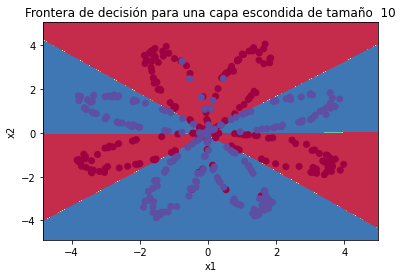

In [25]:
# Construya un modelo con una capa escondida de dimensión $n_h=10$
seed=39

n_h=10
param = modelo_red(X, Y, n_h, num_iter = 10000, tasa=0.01, print_c=True, semilla=seed)

# Grafique la frontera de decisión
plot_frontera_decision(lambda x: pred(param, x.T), X, Y2)
plt.title("Frontera de decisión para una capa escondida de tamaño  " + str(n_h))

**Salida esperada**:

<table style="width:50%">
<tr> 
<td>Coste tras la iteración 9000</td>
<td> 0.361672 </td> 
</tr>
</table>

Veamos la EXACTITUD del modelo:

In [26]:
# Mostramos la exactitud
prediccion = pred(param, X)
print ('Exactitud: %d' % float((np.dot(Y,prediccion.T) + np.dot(1-Y,1-prediccion.T))/float(Y.size)*100) + '%')

Exactitud: 93%


**Salida esperada**: 

<table style="width:35%">
<tr>
<td>Exactitud</td>
<td> 90% </td> 
</tr>
</table>

Ahora veamos la accuracy en prediccion con nuevos datos:

In [27]:
semilla=999  #tomamos una semilla distinta
m = 400 # numero de ejemplos

X_prueba, Y_prueba = datos_nl(semilla,m)

# Accuracy de prueba
pred_prueba = pred(param, X_prueba)
print ('Exactitud: %d' % float((np.dot(Y_prueba,pred_prueba.T) + np.dot(1-Y_prueba,1-pred_prueba.T))/float(Y_prueba.size)*100) + '%')

Exactitud: 91%


**Salida esperada**: 

<table style="width:35%">
  <tr>
    <td>Exactitud</td>
    <td> 87% </td> 
  </tr>
</table>

La exactitud ($accuracy$) es alta comparada con los resultados de la regresión logística. El modelo de red neuronal sencilla ha aprendido a generalizar el comportameinto de $Y$ sobre los datos de la muestra. 

Hemos podido verificar que las redes neuronales pueden aprender fronteras de decisión en alto grado no-lineales, a diferencia de la regresión logística. 

Ahora, encontremos el mejor modelo al intentar distintos tamaños de la capa escondida.

### Ejercicio 4.5.3

Mediante un conjunto de posibles tamaños para la capa escondida (numero de neuronas en la capa escondida): num_neuronas = [1, 2, .. , H], encuentre el valor que logre el mejor ajuste sobre los datos de entrenamiento. 

Analize los distintos comportamientos del modelo para distintos tamaños de la capa escondida. 

Coste tras la iteración 0: 0.693146
Coste tras la iteración 1000: 0.609488
Coste tras la iteración 2000: 0.607760
Coste tras la iteración 3000: 0.606824
Coste tras la iteración 4000: 0.606211
Coste tras la iteración 5000: 0.605774
Coste tras la iteración 6000: 0.605445
Coste tras la iteración 7000: 0.605189
Coste tras la iteración 8000: 0.604983
Coste tras la iteración 9000: 0.604814
Exactitud para 1 unidades escondidas: 70.75 %
Coste tras la iteración 0: 0.693178
Coste tras la iteración 1000: 0.534014
Coste tras la iteración 2000: 0.530821
Coste tras la iteración 3000: 0.529294
Coste tras la iteración 4000: 0.528370
Coste tras la iteración 5000: 0.527747
Coste tras la iteración 6000: 0.527296
Coste tras la iteración 7000: 0.526955
Coste tras la iteración 8000: 0.526686
Coste tras la iteración 9000: 0.526468
Exactitud para 2 unidades escondidas: 69.75 %
Coste tras la iteración 0: 0.693116
Coste tras la iteración 1000: 0.223641
Coste tras la iteración 2000: 0.216225
Coste tras la iterac

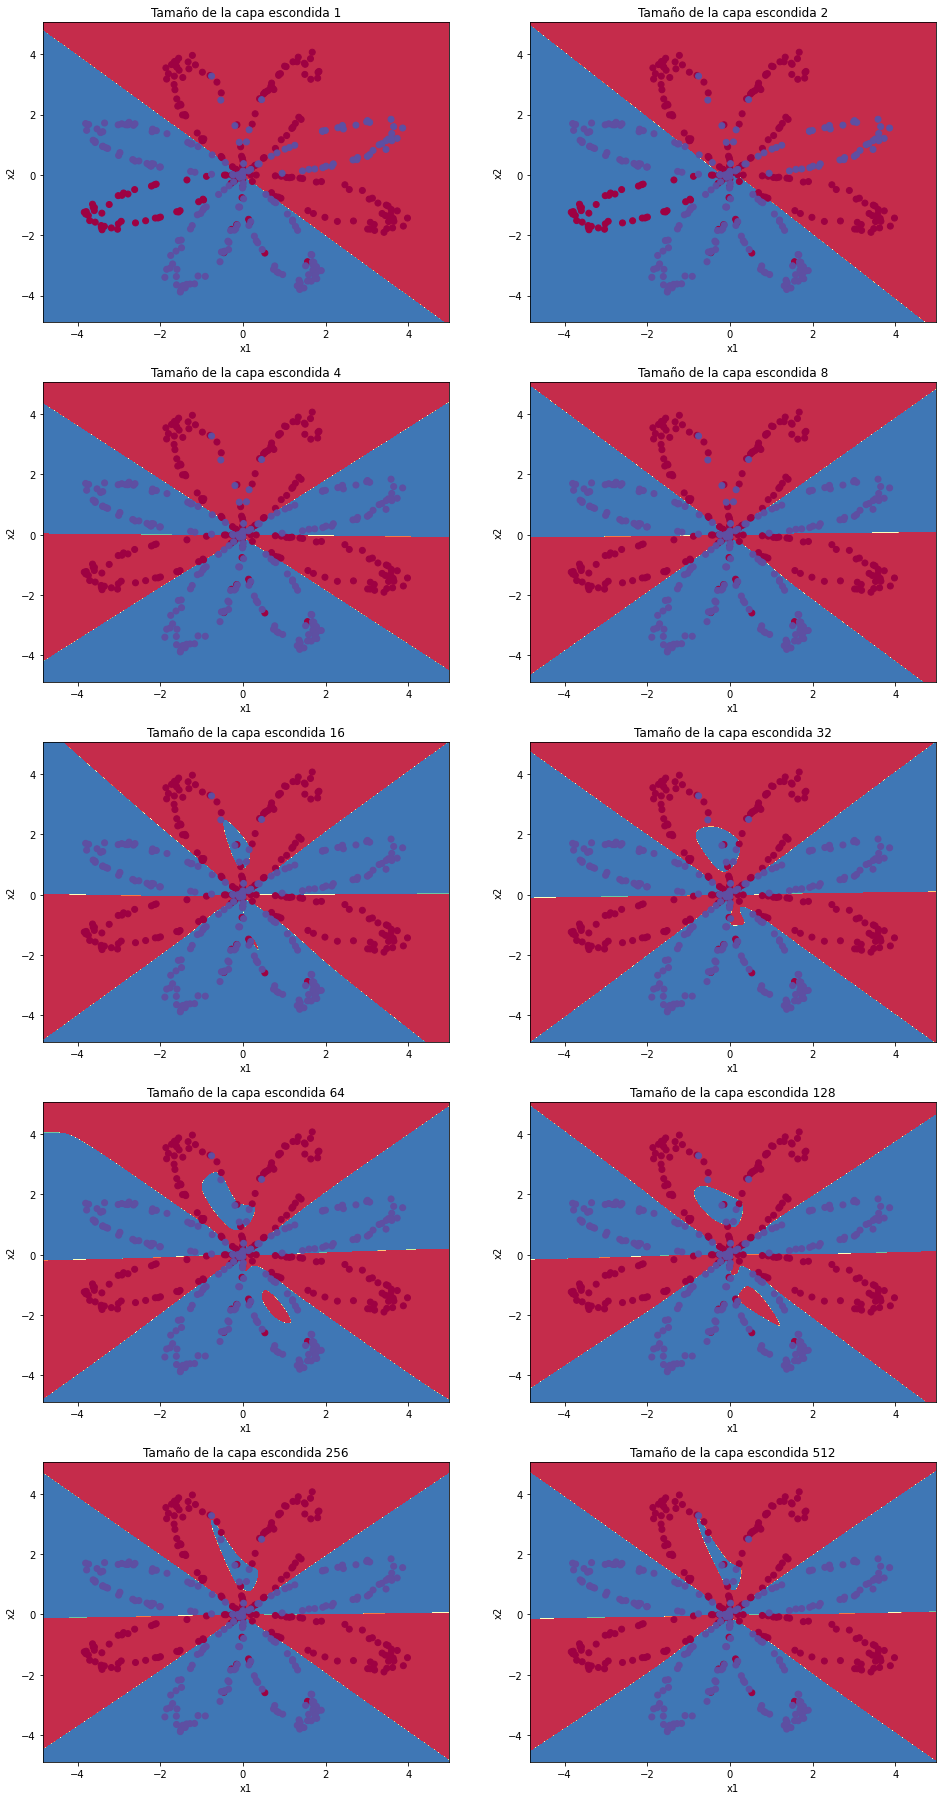

In [28]:
plt.figure(figsize=(16, 32))

num_neuronas = [1,2,4,8,16,32,64,128,256,512]   #

for i, n_h in enumerate(num_neuronas):
    plt.subplot(5, 2, i+1)
    plt.title('Tamaño de la capa escondida %d' % n_h)
    param = modelo_red(X, Y, n_h, num_iter = 10000, tasa=1, print_c=True, semilla=13)
    plot_frontera_decision(lambda x: pred(param, x.T), X, Y2)
    prediccion = pred(param, X)
    Exactitud = float((np.dot(Y,prediccion.T) + np.dot(1-Y,1-prediccion.T))/float(Y.size)*100)
    print ("Exactitud para {} unidades escondidas: {} %".format(n_h, Exactitud))

**Discusión**:
- Modelos más complejos (con más unidades escondidas) logran un mejor ajuste al conjunto de entrenamiento, hasta que eventualmente los modelos más grandes se *sobreajustan* a los datos. 

### Pregunta 4.5.4 

¿Cuál es la mejor configuración del modelo?

Recuerde: el mejor modelo es aquel que logre una mejor generalización de los datos. 



#### Respuesta: Una configuración con 8 unidades escondidas, debido a que logra una exactitud de 94.25 %, la cual es cercana a la máxima exactitud alcanzada 95%, sin embargo, permite generalizar mejor los datos con un uso menor de neuronas.

### Pregunta 4.5.5

¿Qué ocurre si cambiamos la función de activación en la capa de salida de sigmoide a ReLU?

#### Respuesta: Al cambiar la función de activación en la capa de salida a ReLU observamos que la red requiere de muchas mas iteraciones y neuronas para converger y además la precisión alcanzada (85%) es menor a la obtenido con la función sigmoide (95%)

In [29]:
def relu(X):
   return np.maximum(0,X)

In [30]:
def propagacion2(X, param):
    """
    Input: 
    X: datos de entrada de tamaño (n_x, m)
    param: diccionario python con los parameters (salida de la funcion de inicialización)
    Output:
    A2: la salida de la función sigmoide de la segunda activación
    memo: un diccionario conteniendo "Z1", "A1", "Z2" y "A2"
    """
    # Recupera cada parámetro del diccionario "param"
    W1 = param["W1"]
    b1 = param["b1"]
    W2 = param["W2"]
    b2 = param["b2"]
    
    # Implemente la propagación hacia delante para calcular las probabilidades A2 
    Z1 = np.dot(W1,X)+b1
    A1 = np.tanh(Z1)
    Z2 = np.dot(W2,A1)+b2
    A2 = relu(Z2)
    
    assert(A2.shape == (1, X.shape[1]))
    
    memo = {"Z1": Z1,
             "A1": A1,
             "Z2": Z2,
             "A2": A2}
    
    return A2, memo

In [31]:
def modelo_red2(X, Y, n_h, num_iter, tasa, print_c, semilla):
    """
    Input:
    X: datos de entrada 
    Y: vector de etiquetas  
    n_h: tamaño de la capa escondida
    num_iter: numero de iteraciones del bucle del GD
    tasa: tasa de aprendizaje
    print_c: si "True", muestra el coste cada 1000 iteraciones
    semilla: semilla aleatoria
    Output:
    param: parametros aprendidos para el modelo final. Se utilizan para la predicción
    """

    n_x = X.shape[0]
    n_y = Y.shape[0]
    
    # Inicializa los parámetros y carga W1, b1, W2, b2. 
    # Inputs: "n_x, n_h, n_y, semilla". Outputs = "W1, b1, W2, b2, parametros".
    param = param_I(n_x, n_h, n_y, semilla)
    W1 = param["W1"]
    b1 = param["b1"]
    W2 = param["W2"]
    b2 = param["b2"]
    
    # Bucle (GD)
    for i in range(0, num_iter):
         
        # Propagación hacia delante. 
        # Inputs: "X, param". Outputs: "A2, memo".
        A2, memo = propagacion2(X, param)
        
        # Función de coste. 
        # Inputs: "A2, Y, param". Outputs: "coste".
        coste = perdida(A2, Y)
 
        # Retro-propagacion. 
        # Inputs: "param, memo, X, Y". Outputs: "grads".
        grads = retro(param, memo, X, Y)
 
        # Actualizacion de parametros por GD. 
        # Inputs: "param, grads, tasa". Outputs: "param".
        param = rev_param(param, grads, tasa=1.2)
              
        # Muestre el coste cada 1000 iteraciones
        if print_c and i % 1000 == 0:
            print ("Coste tras la iteración %i: %f" %(i, coste))

    return param

In [32]:
param = modelo_red(X, Y, n_h=4, num_iter=10000, tasa=2.5, print_c=True, semilla=0)

Coste tras la iteración 0: 0.693165
Coste tras la iteración 1000: 0.223759
Coste tras la iteración 2000: 0.216800
Coste tras la iteración 3000: 0.211363
Coste tras la iteración 4000: 0.207004
Coste tras la iteración 5000: 0.204526
Coste tras la iteración 6000: 0.203150
Coste tras la iteración 7000: 0.202390
Coste tras la iteración 8000: 0.201942
Coste tras la iteración 9000: 0.201646


Coste tras la iteración 0: nan


<ipython-input-15-dba0cc7ea7bd>:15: RuntimeWarning: divide by zero encountered in log
  coste = -1/m*np.sum(Y*np.log(A2)+(1-Y)*np.log(1-A2))                        # no hay necesidad de usar un bucle!
<ipython-input-15-dba0cc7ea7bd>:15: RuntimeWarning: invalid value encountered in multiply
  coste = -1/m*np.sum(Y*np.log(A2)+(1-Y)*np.log(1-A2))                        # no hay necesidad de usar un bucle!
<ipython-input-15-dba0cc7ea7bd>:15: RuntimeWarning: invalid value encountered in log
  coste = -1/m*np.sum(Y*np.log(A2)+(1-Y)*np.log(1-A2))                        # no hay necesidad de usar un bucle!


Coste tras la iteración 1000: 0.653694
Coste tras la iteración 2000: 0.653622
Coste tras la iteración 3000: nan
Coste tras la iteración 4000: nan
Coste tras la iteración 5000: 0.710938
Coste tras la iteración 6000: 0.723691
Coste tras la iteración 7000: 0.728785
Coste tras la iteración 8000: 0.730360
Coste tras la iteración 9000: 0.730187
Exactitud para 1 unidades escondidas: 50.0 %
Coste tras la iteración 0: nan
Coste tras la iteración 1000: 0.543755
Coste tras la iteración 2000: 0.538656
Coste tras la iteración 3000: 0.535934
Coste tras la iteración 4000: 0.534154
Coste tras la iteración 5000: 0.532866
Coste tras la iteración 6000: 0.531874
Coste tras la iteración 7000: 0.531078
Coste tras la iteración 8000: 0.530419
Coste tras la iteración 9000: 0.529862
Exactitud para 2 unidades escondidas: 50.0 %
Coste tras la iteración 0: nan
Coste tras la iteración 1000: nan
Coste tras la iteración 2000: nan
Coste tras la iteración 3000: nan
Coste tras la iteración 4000: nan
Coste tras la iterac

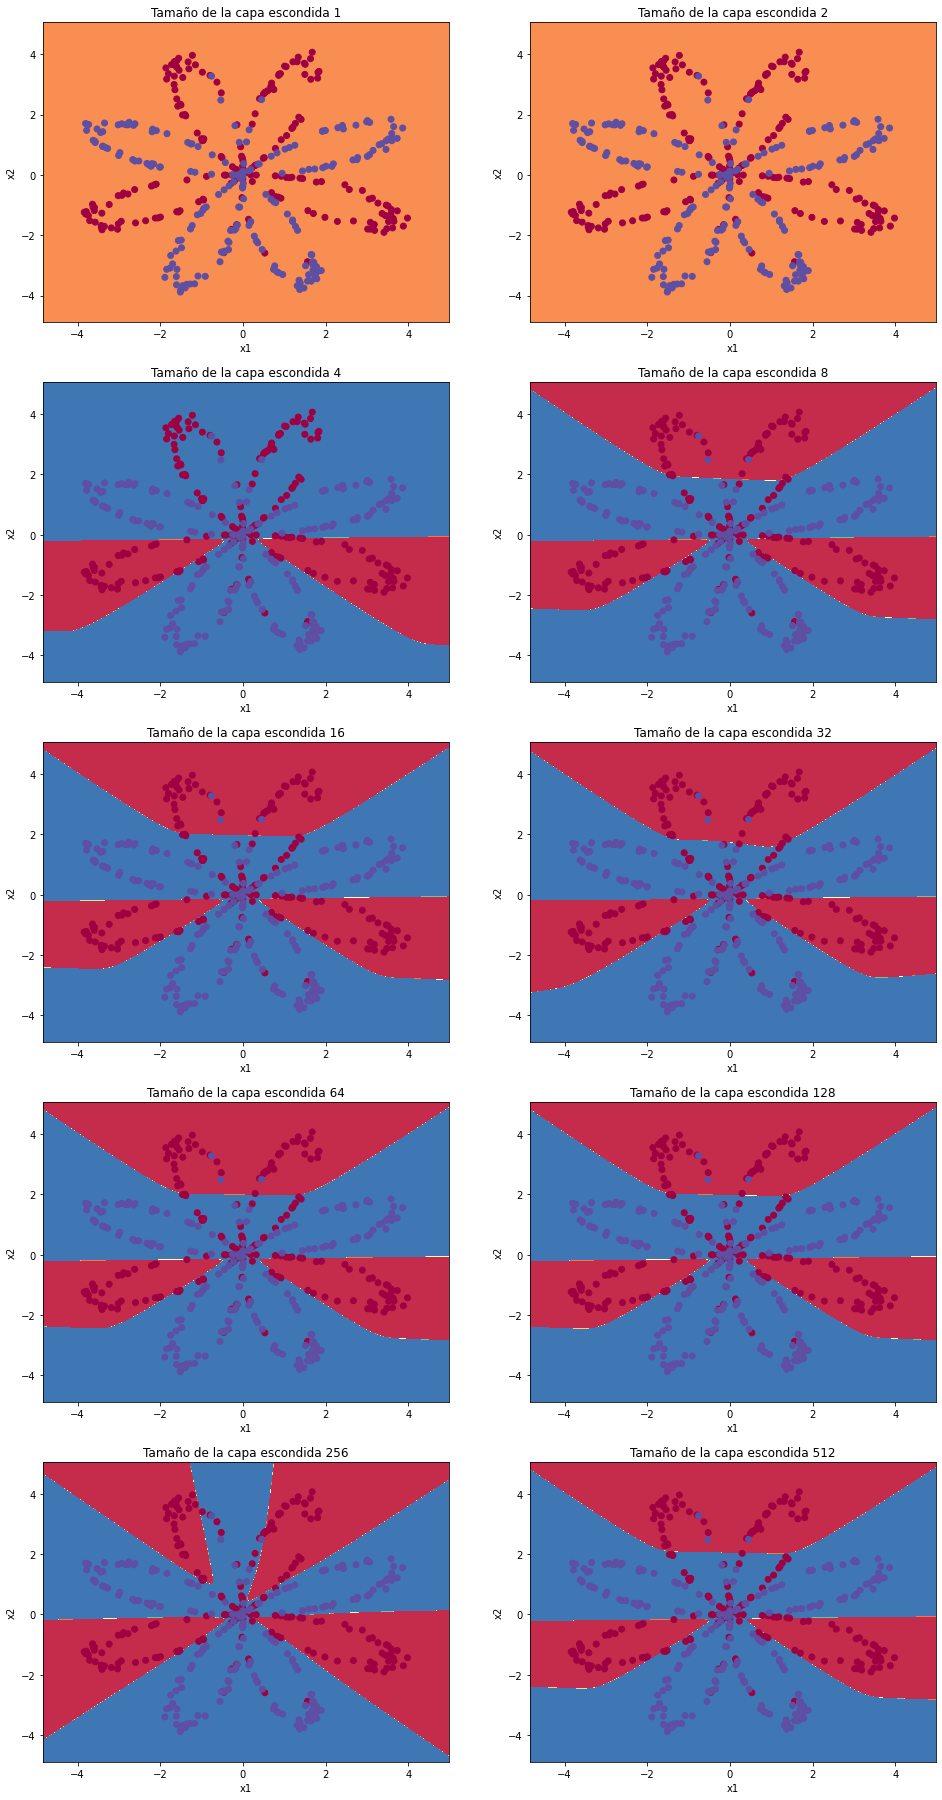

In [33]:
plt.figure(figsize=(16, 32))

num_neuronas = [1,2,4,8,16,32,64,128,256,512]   #

for i, n_h in enumerate(num_neuronas):
    plt.subplot(5, 2, i+1)
    plt.title('Tamaño de la capa escondida %d' % n_h)
    param = modelo_red2(X, Y, n_h, num_iter = 10000, tasa=1, print_c=True, semilla=13)
    plot_frontera_decision(lambda x: pred(param, x.T), X, Y2)
    prediccion = pred(param, X)
    Exactitud = float((np.dot(Y,prediccion.T) + np.dot(1-Y,1-prediccion.T))/float(Y.size)*100)
    print ("Exactitud para {} unidades escondidas: {} %".format(n_h, Exactitud))

Felicitaciones, ha llegado al final de la actividad, estudiando en detalle conceptos clave para calibrar un modelo de red neuronal. Para finalizar, a continuación veamos un caso de estudio con imagenes. Vamos a probar una red neuronal sencilla para la deteccion automática de plantas nativas a partir de imagenes aereas del paramo de Chingaza y Cruz Verde.

Este caso de estudio hace parte de un proyecto de Ingeniería que busca preservar y monitorizar el ecosistema del páramo, de gran importancia por su potencial hídrico, mediante la propuesta de una metodología para la reconstrucción del ecosistema en zonas de baja densidad de poblaciones de la especia *Espeletia*. 

## 5. Caso aplicado

Construyamos una red sencilla para detectar automáticamente frailejones sobre imagenes aereas del páramo. 

A continuación, modifique el  código de ``modelo_red()``, en una nueva funcion llamada ``modelo_red2()``, que permita:

- Incluir una partición de los datos de entrada que contenga un conjunto de datos de entrenamiento y otro de validación. Los datos de validación deben contener información diferente a la de entrenamiento con el fin de evaluar el desempeño del modelo para generalizar datos desconocidos. 

- Recuperar la mejor época (iteración) para el modelo de acuerdo con su desempeño en validación

Luego implemente un código que permita identificar un *mejor* modelo de acuerdo con su desempeño en validación, el cual logre ajustar y generalizar los datos de entrenamiento lo mejor posible.

Una vez tengamos nuestro modelo lo podremos poner a prueba sobre una nueva imagen.


Escribamos nuestra nueva función:

In [34]:
def modelo_red2(X, Y, xV, yV, n_h, num_iter, tasa, semilla, print_c):
    """
    Input:
    X: datos de entrada 
    Y: vector de etiquetas 
    xV: datos de validacion
    yV: etiquetas de validación
    n_h: tamaño de la capa escondida
    num_iter: numero de iteraciones del bucle del GD
    tasa: tasa de aprendizaje
    print_c: si "True", muestra el coste cada 1000 iteraciones
    semilla: semilla aleatoria para la inicializacion de los pesos
    Output:
    param: parametros aprendidos para el modelo final. Se utilizan para la predicción
    """

    n_x = X.shape[0]
    n_y = Y.shape[0]
    
    costes = [] 
    costes2 = [] 
    coste_aux= 99
    epoc=0
    
    # Inicializa los parámetros y carga W1, b1, W2, b2. 
    # Inputs: "n_x, n_h, n_y". Outputs = "W1, b1, W2, b2, parametros".
    param = param_I(n_x, n_h, n_y, semilla)
    W1 = param["W1"]
    b1 = param["b1"]
    W2 = param["W2"]
    b2 = param["b2"]
    
    # Bucle (GD)
    for i in range(0, num_iter):
         
        # Propagación hacia delante. 
        # Inputs: "X, param". Outputs: "A2, memo".
        A2, memo = propagacion(X, param)
        A2V, memo2 = propagacion(xV, param)                     # Propagacion hacia delante para la validacion
        
        # Función de perdida 
        # Inputs: "A2, Y". Outputs: "coste".
        coste = perdida(A2, Y) 
        
        # coste de validacion
        coste2 = perdida(A2V, yV)                        # Perdida para la validacion
 
        # Retro-propagacion. 
        # Inputs: "param, memo, X, Y". Outputs: "grads".
        grads = retro(param, memo, X, Y)
 
        # Actualizacion de parametros por GD. 
        # Inputs: "param, grads". Outputs: "param".
        param = rev_param(param, grads, tasa )
        
        
        # Muestre el coste cada 1000 iteraciones
        if print_c and i % 1000 == 0:
            print ("Coste tras la iteración %i: %f" %(i, coste))
        if print_c and i % 100 == 0:
            costes.append(coste)
            costes2.append(coste2)
            
            # Me quedo con la mejor época en validacion
        if coste2 < coste_aux:
            coste_aux=coste2
            epoc = i
                
            
    # grafique el coste
    if print_c:
        plt.plot(np.squeeze(costes), marker="o", label="CE")
        plt.plot(np.squeeze(costes2), marker="*" , label="CV")
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        plt.ylabel('Coste')
        plt.xlabel('Epocas*100')
        plt.title("Tasa de aprendizaje= " + str(tasa))
        plt.savefig("fig1"+str(i)+".png")
        plt.show()
        print("Mejor iteracion es: " +str(epoc) +" con la semilla: " +str(semilla))

    return param, epoc

Carguemos los datos de las imagenes:

In [35]:
from ImportImagenes import *
from sklearn.model_selection import train_test_split

In [36]:
X,Y = import_imagenes()

CE_x, CV_x, CE_y, CV_y = train_test_split(X.T, Y.T, test_size = 0.3, random_state = 100)

CE_x = CE_x.T
CV_x = CV_x.T
CE_y = CE_y.T
CV_y = CV_y.T

n=CE_y.shape[1]
m=CV_y.shape[1]

print(CE_x.shape, CV_x.shape, CE_y.shape, CV_y.shape, n, m)

(14700, 175) (14700, 75) (1, 175) (1, 75) 175 75


Veamos que el código funciona, por ejemplo con 2 neuronas:

Coste tras la iteración 0: 0.693884
Coste tras la iteración 1000: 0.385079
Coste tras la iteración 2000: 0.111019
Coste tras la iteración 3000: 0.083221
Coste tras la iteración 4000: 0.077025
Coste tras la iteración 5000: 0.070149
Coste tras la iteración 6000: 0.050544
Coste tras la iteración 7000: 0.048152
Coste tras la iteración 8000: 0.046767
Coste tras la iteración 9000: 0.045841


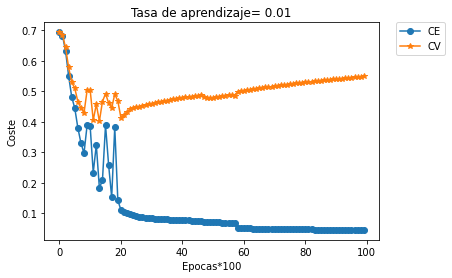

Mejor iteracion es: 1506 con la semilla: 39


In [37]:
seed=39

n_h=2
param, epoc = modelo_red2(CE_x, CE_y, CV_x, CV_y, n_h, num_iter = 10000, tasa=0.01, semilla=seed, print_c=True)


### Identificación del mejor modelo de red con una capa escondida

A continuación encontremos el mejor modelo con respecto al numero de neuronas que debemos incluir:
Vamos a usar ``prettytable`` para resumir los resultados en una tabla. Para ello, instalamos PTable desde el prompt de Anaconda: `` conda install -c conda-forge prettytable``

Con el fin de identificar el número óptimo de neuronas en la capa escondida, vamos a hacer una búsqueda de 1 a 20 neuronas y elegimos para cada configuración el número óptimo de épocas definiendo un numero maximo de epocas de 3000, y una tasa de aprendizaje de 0.01:

Coste tras la iteración 0: 0.692456
Coste tras la iteración 1000: 0.679369
Coste tras la iteración 2000: 0.679360


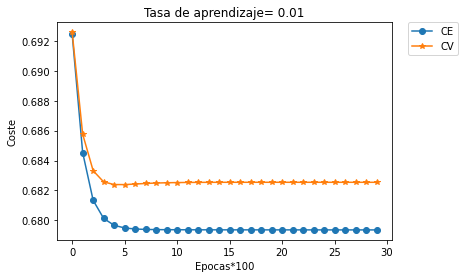

Mejor iteracion es: 448 con la semilla: 99
Número de neuronas: 1
Predv         0.0
Actualv          
0        0.573333
1        0.426667
Accuracy entrenamiento: 0.582857142857143  y accuracy validación: 0.5733333333333334
Coste tras la iteración 0: 0.693882
Coste tras la iteración 1000: 0.312660
Coste tras la iteración 2000: 0.226879


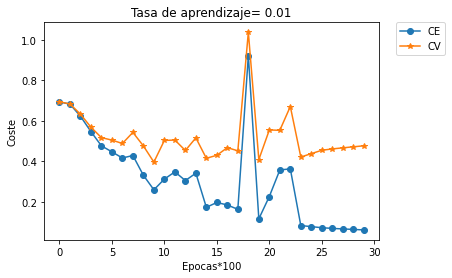

Mejor iteracion es: 1217 con la semilla: 99
Número de neuronas: 2
Predv         0.0       1.0
Actualv                    
0        0.880952  0.181818
1        0.119048  0.818182
Accuracy entrenamiento: 0.9314285714285715  y accuracy validación: 0.8533333333333333
Coste tras la iteración 0: 0.693082
Coste tras la iteración 1000: 0.366620
Coste tras la iteración 2000: 0.175626


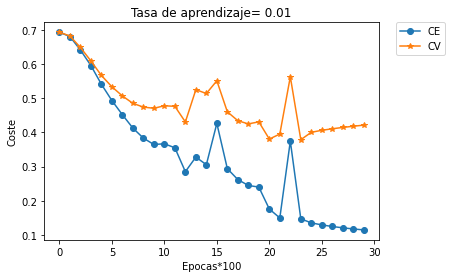

Mejor iteracion es: 2264 con la semilla: 99
Número de neuronas: 3
Predv         0.0      1.0
Actualv                   
0        0.863636  0.16129
1        0.136364  0.83871
Accuracy entrenamiento: 0.9714285714285713  y accuracy validación: 0.8533333333333333
Coste tras la iteración 0: 0.692500
Coste tras la iteración 1000: 0.224674
Coste tras la iteración 2000: 0.227464


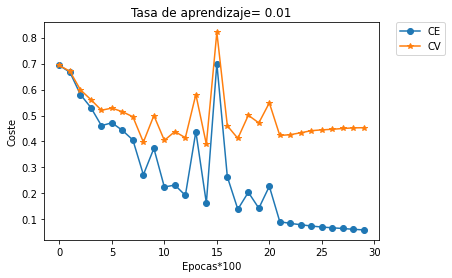

Mejor iteracion es: 1083 con la semilla: 99
Número de neuronas: 4
Predv         0.0       1.0
Actualv                    
0        0.847826  0.137931
1        0.152174  0.862069
Accuracy entrenamiento: 0.9314285714285715  y accuracy validación: 0.8533333333333333
Coste tras la iteración 0: 0.693050
Coste tras la iteración 1000: 0.338751
Coste tras la iteración 2000: 0.198237


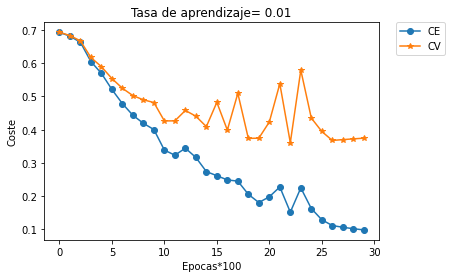

Mejor iteracion es: 2123 con la semilla: 99
Número de neuronas: 5
Predv         0.0      1.0
Actualv                   
0        0.883721  0.15625
1        0.116279  0.84375
Accuracy entrenamiento: 0.9771428571428571  y accuracy validación: 0.8666666666666667
Coste tras la iteración 0: 0.692827
Coste tras la iteración 1000: 0.392017
Coste tras la iteración 2000: 0.073364


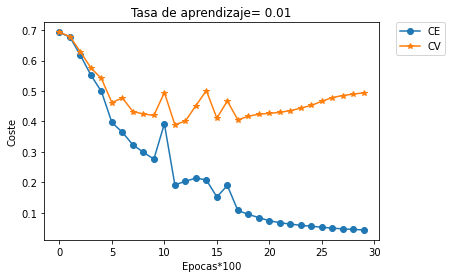

Mejor iteracion es: 1071 con la semilla: 99
Número de neuronas: 6
Predv     0.0   1.0
Actualv            
0        0.78  0.16
1        0.22  0.84
Accuracy entrenamiento: 0.9314285714285715  y accuracy validación: 0.8
Coste tras la iteración 0: 0.693058
Coste tras la iteración 1000: 0.248932
Coste tras la iteración 2000: 0.107907


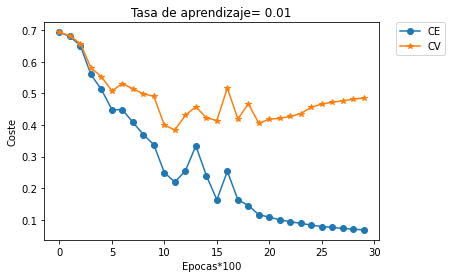

Mejor iteracion es: 1185 con la semilla: 99
Número de neuronas: 7
Predv         0.0       1.0
Actualv                    
0        0.829787  0.142857
1        0.170213  0.857143
Accuracy entrenamiento: 0.9257142857142858  y accuracy validación: 0.84
Coste tras la iteración 0: 0.695372
Coste tras la iteración 1000: 0.219050
Coste tras la iteración 2000: 0.057642


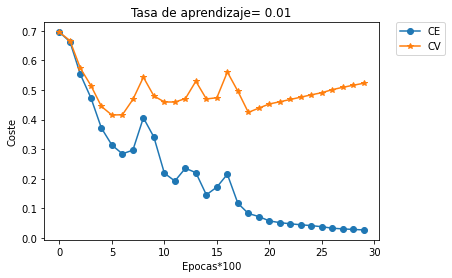

Mejor iteracion es: 1113 con la semilla: 99
Número de neuronas: 8
Predv         0.0       1.0
Actualv                    
0        0.866667  0.133333
1        0.133333  0.866667
Accuracy entrenamiento: 0.9314285714285715  y accuracy validación: 0.8666666666666667
Coste tras la iteración 0: 0.692791
Coste tras la iteración 1000: 0.200400
Coste tras la iteración 2000: 0.056491


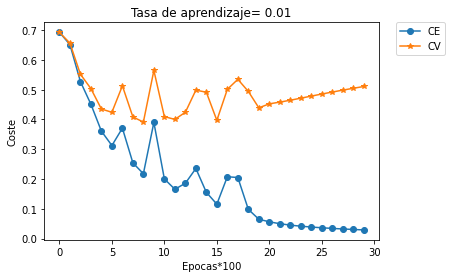

Mejor iteracion es: 1763 con la semilla: 99
Número de neuronas: 9
Predv         0.0       1.0
Actualv                    
0        0.808511  0.178571
1        0.191489  0.821429
Accuracy entrenamiento: 0.937142857142857  y accuracy validación: 0.8133333333333332
Coste tras la iteración 0: 0.692651
Coste tras la iteración 1000: 0.324308
Coste tras la iteración 2000: 0.059445


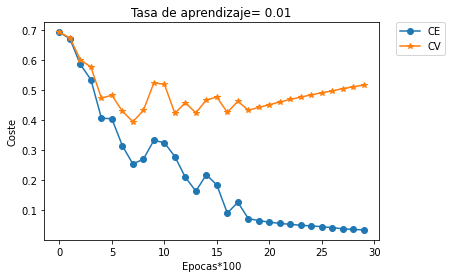

Mejor iteracion es: 1266 con la semilla: 99
Número de neuronas: 10
Predv         0.0       1.0
Actualv                    
0        0.886364  0.129032
1        0.113636  0.870968
Accuracy entrenamiento: 0.9542857142857142  y accuracy validación: 0.88
Coste tras la iteración 0: 0.694044
Coste tras la iteración 1000: 0.193287
Coste tras la iteración 2000: 0.049353


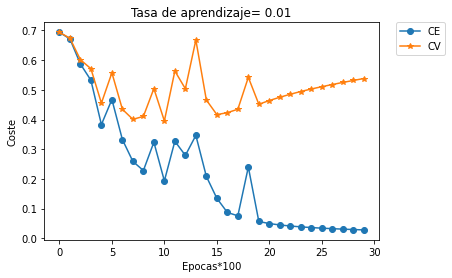

Mejor iteracion es: 953 con la semilla: 99
Número de neuronas: 11
Predv         0.0      1.0
Actualv                   
0        0.863636  0.16129
1        0.136364  0.83871
Accuracy entrenamiento: 0.9257142857142858  y accuracy validación: 0.8533333333333333
Coste tras la iteración 0: 0.695684
Coste tras la iteración 1000: 0.237681
Coste tras la iteración 2000: 0.066151


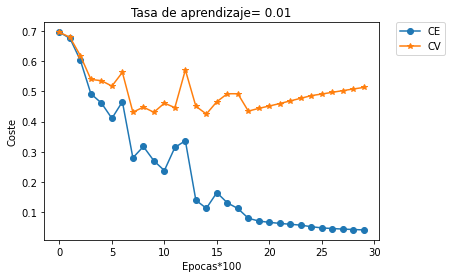

Mejor iteracion es: 1065 con la semilla: 99
Número de neuronas: 12
Predv         0.0      1.0
Actualv                   
0        0.883721  0.15625
1        0.116279  0.84375
Accuracy entrenamiento: 0.9371428571428573  y accuracy validación: 0.8666666666666667
Coste tras la iteración 0: 0.695917
Coste tras la iteración 1000: 0.350432
Coste tras la iteración 2000: 0.041320


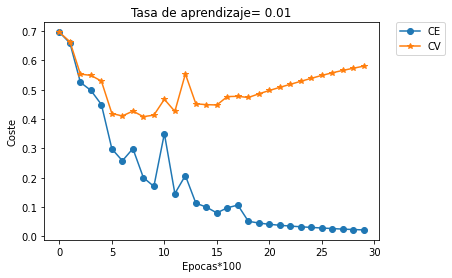

Mejor iteracion es: 807 con la semilla: 99
Número de neuronas: 13
Predv         0.0       1.0
Actualv                    
0        0.880952  0.181818
1        0.119048  0.818182
Accuracy entrenamiento: 0.9257142857142858  y accuracy validación: 0.8533333333333333
Coste tras la iteración 0: 0.691771
Coste tras la iteración 1000: 0.252602
Coste tras la iteración 2000: 0.043723


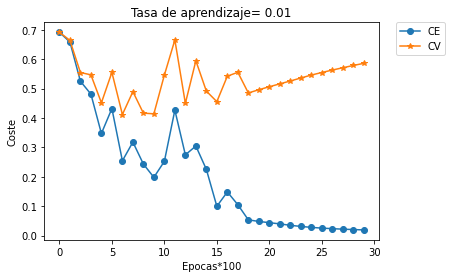

Mejor iteracion es: 883 con la semilla: 99
Número de neuronas: 14
Predv         0.0      1.0
Actualv                   
0        0.863636  0.16129
1        0.136364  0.83871
Accuracy entrenamiento: 0.9314285714285715  y accuracy validación: 0.8533333333333333
Coste tras la iteración 0: 0.693948
Coste tras la iteración 1000: 0.157281
Coste tras la iteración 2000: 0.047232


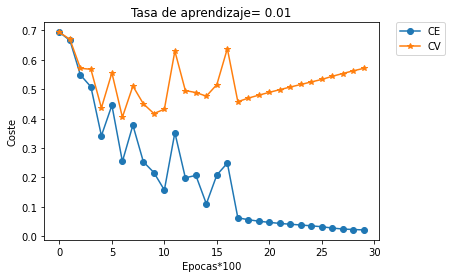

Mejor iteracion es: 1017 con la semilla: 99
Número de neuronas: 15
Predv         0.0       1.0
Actualv                    
0        0.866667  0.133333
1        0.133333  0.866667
Accuracy entrenamiento: 0.9371428571428573  y accuracy validación: 0.8666666666666667
Coste tras la iteración 0: 0.691814
Coste tras la iteración 1000: 0.374486
Coste tras la iteración 2000: 0.038915


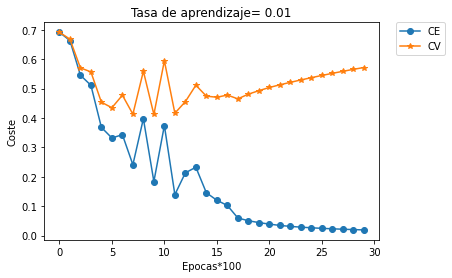

Mejor iteracion es: 692 con la semilla: 99
Número de neuronas: 16
Predv         0.0       1.0
Actualv                    
0        0.844444  0.166667
1        0.155556  0.833333
Accuracy entrenamiento: 0.92  y accuracy validación: 0.84
Coste tras la iteración 0: 0.694666
Coste tras la iteración 1000: 0.238438
Coste tras la iteración 2000: 0.038229


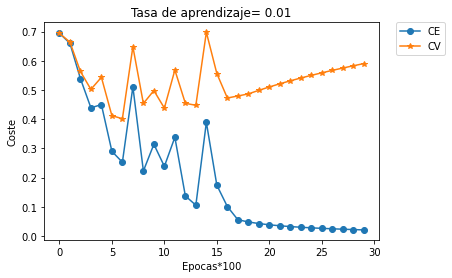

Mejor iteracion es: 806 con la semilla: 99
Número de neuronas: 17
Predv         0.0      1.0
Actualv                   
0        0.863636  0.16129
1        0.136364  0.83871
Accuracy entrenamiento: 0.9257142857142857  y accuracy validación: 0.8533333333333333
Coste tras la iteración 0: 0.691798
Coste tras la iteración 1000: 0.221564
Coste tras la iteración 2000: 0.030886


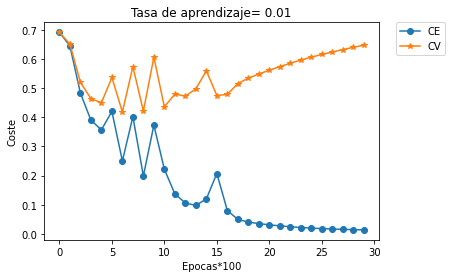

Mejor iteracion es: 774 con la semilla: 99
Número de neuronas: 18
Predv         0.0       1.0
Actualv                    
0        0.844444  0.166667
1        0.155556  0.833333
Accuracy entrenamiento: 0.9257142857142857  y accuracy validación: 0.84
Coste tras la iteración 0: 0.694170
Coste tras la iteración 1000: 0.205190
Coste tras la iteración 2000: 0.033924


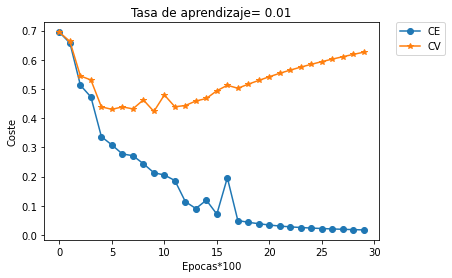

Mejor iteracion es: 566 con la semilla: 99
Número de neuronas: 19
Predv         0.0       1.0
Actualv                    
0        0.808511  0.178571
1        0.191489  0.821429
Accuracy entrenamiento: 0.9085714285714286  y accuracy validación: 0.8133333333333334
Coste tras la iteración 0: 0.693206
Coste tras la iteración 1000: 0.524715
Coste tras la iteración 2000: 0.031348


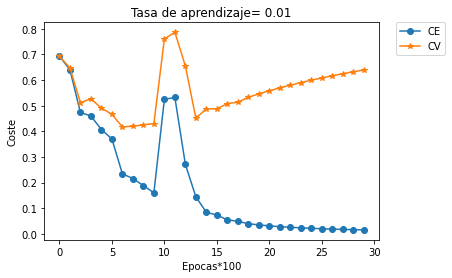

Mejor iteracion es: 540 con la semilla: 99
Número de neuronas: 20
Predv         0.0       1.0
Actualv                    
0        0.808511  0.178571
1        0.191489  0.821429
Accuracy entrenamiento: 0.92  y accuracy validación: 0.8133333333333334
+----------+--------------------+--------------------+-------+
| NNeurons |       Acc_E        |       Acc_V        | epoca |
+----------+--------------------+--------------------+-------+
|    1     | 0.582857142857143  | 0.5733333333333334 |  448  |
|    2     | 0.9314285714285715 | 0.8533333333333333 |  1217 |
|    3     | 0.9714285714285713 | 0.8533333333333333 |  2264 |
|    4     | 0.9314285714285715 | 0.8533333333333333 |  1083 |
|    5     | 0.9771428571428571 | 0.8666666666666667 |  2123 |
|    6     | 0.9314285714285715 |        0.8         |  1071 |
|    7     | 0.9257142857142858 |        0.84        |  1185 |
|    8     | 0.9314285714285715 | 0.8666666666666667 |  1113 |
|    9     | 0.937142857142857  | 0.8133333333333332 |  1

In [38]:
import pandas as pd
from prettytable import PrettyTable

x = PrettyTable(["NNeurons", "Acc_E", "Acc_V", "epoca"])

for i in range(1,21):
    param, epoc = modelo_red2(CE_x, CE_y, CV_x, CV_y, n_h = i, num_iter = 3000, tasa = 0.01, semilla = 99, print_c=True)
    # nos quedamos con el mejor numero de epocas
    param, epoc = modelo_red2(CE_x, CE_y, CV_x, CV_y, n_h = i, num_iter = (epoc+1), tasa = 0.01, semilla = 99, print_c=False)
    
    # predicciones
    pE=pred(param, CE_x)
    pV=pred(param, CV_x)
    
    # Accuracy
    # entrenamiento
    Acc_e = np.sum((pE == CE_y)/n)
    
    # validacion
    Acc_v = np.sum((pV == CV_y)/m)
    
    #matrices de confusion para train y validacion
    ye_actu = pd.Series(CE_y.ravel(), name='Actuale')
    ye_pred = pd.Series(pE.ravel(), name='Prede')
   
    df_confusione = pd.crosstab(ye_actu, ye_pred).apply(lambda r: r/r.sum(), axis=0) 
    
    yv_actu = pd.Series(CV_y.ravel(), name='Actualv')
    yv_pred = pd.Series(pV.ravel(), name='Predv')
   
    df_confusionv = pd.crosstab(yv_actu, yv_pred).apply(lambda r: r/r.sum(), axis=0) 
    
    print("Número de neuronas: " +str(i))
    print(df_confusionv)
    print("Accuracy entrenamiento: "  + str(Acc_e), " y accuracy validación: " + str(Acc_v) )
    
    x.add_row([i, Acc_e, Acc_v, epoc])
         
print(x)

Probemos nuestro modelo sobre una nueva imagen. Para ello cargamos la imagen ``IMG_3451.JPG`` con ayuda de la API ``Keras`` (https://keras.io/), compatible con múltiples marcos computacionales para el aprendizaje computacional, como Theano, CNTK, siendo el marco oficial para  ``TensorFlow`` (https://www.tensorflow.org/guide/keras/overview).

Debemos instalar e importar ``Keras``:

`` conda install -c conda-forge keras``

Cualquier duda para la instalacion de paquetes de software desde Anaconda: https://anaconda.org/conda-forge/keras
Esta API la vamos a utilizar más exhaustivamente cuando veamos redes más complejas.

In [39]:
import keras

Cargamos nuestro mejor modelo y lo pasamos por la imagen en busca de frailejones:

In [41]:
# Obtenemos el modelo
param, epoc = modelo_red2(CE_x, CE_y, CV_x, CV_y, n_h = 5, num_iter = 2527, tasa = 0.01, semilla = 99, print_c=False)
param

{'W1': array([[-0.00084955,  0.02114836,  0.0032518 , ..., -0.01722412,
         -0.0057897 ,  0.01844344],
        [ 0.00610311,  0.04288078,  0.03834463, ..., -0.06087905,
         -0.08079484, -0.07031661],
        [ 0.01667628,  0.00230342, -0.00392709, ...,  0.0085377 ,
         -0.01069965, -0.00442006],
        [ 0.00104673,  0.00252776,  0.00037561, ...,  0.00553148,
         -0.01965711,  0.00684947],
        [-0.01298192,  0.01960857, -0.02861052, ...,  0.00960069,
          0.00209304, -0.00181424]]),
 'b1': array([[ 0.00120186],
        [-0.10084992],
        [-0.00169363],
        [-0.00163056],
        [ 0.00140911]]),
 'W2': array([[-0.07453117,  2.39010196,  0.08470657,  0.04313908, -0.10751379]]),
 'b2': array([[-0.10632671]])}

### Pregunta 5.1

A partir de esta prueba *cualitativa* del modelo, y junto con las estadísticas obtenidas en su desarrollo, analice los resultados y proponga estrategias para seguir mejorando el modelo para la detección automática de especies nativas en los páramos. 

### Respuesta

#### Modificamos la inicialización de parametros por una inicialización He, además reducimos el numero de iteraciones a 2000, la tasa de aprendizaje se mantiene en 0.01 debido a que ningun otro valor mejoraba el poder predictivo de la red.

In [87]:

def param_I(n_x, n_h, n_y, semilla):
    """
    Input:
    n_x: tamaño de la capa de entrada
    n_h: tamaño de la capa escondida
    n_y: tamaño de la capa de salida
    Output:
    param: diccionario python con los parámetros:
            W1: matriz de pesos con dimensiones (n_h, n_x)
            b1: matriz de sesgos con dimensiones (n_h, 1)
            W2: matriz de pesos con dimensiones (n_y, n_h)
            b2: matriz de sesgos con dimensiones (n_y, 1)
    """
    np.random.seed(semilla)
    
    W1 = np.random.randn(n_h,n_x) * np.sqrt(2/n_x)
    b1 = np.zeros((n_h,1))
    W2 = np.random.randn(n_y,n_h) * np.sqrt(2/n_h)
    b2 = np.zeros((n_y,1))
    
    assert (W1.shape == (n_h, n_x))
    assert (b1.shape == (n_h, 1))
    assert (W2.shape == (n_y, n_h))
    assert (b2.shape == (n_y, 1))
    
    param = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return param

Coste tras la iteración 0: 0.965998
Coste tras la iteración 1000: 0.679392


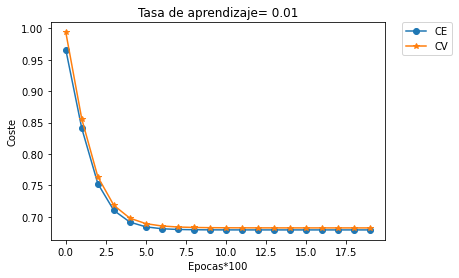

Mejor iteracion es: 1999 con la semilla: 99
Número de neuronas: 1
Predv         0.0
Actualv          
0        0.573333
1        0.426667
Accuracy entrenamiento: 0.582857142857143  y accuracy validación: 0.5733333333333334
Coste tras la iteración 0: 1.000574
Coste tras la iteración 1000: 0.546913


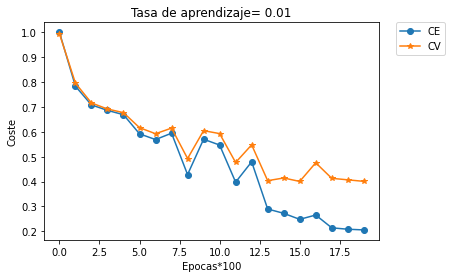

Mejor iteracion es: 1998 con la semilla: 99
Número de neuronas: 2
Predv         0.0      1.0
Actualv                   
0        0.863636  0.16129
1        0.136364  0.83871
Accuracy entrenamiento: 0.9542857142857143  y accuracy validación: 0.8533333333333333
Coste tras la iteración 0: 0.687841
Coste tras la iteración 1000: 0.385336


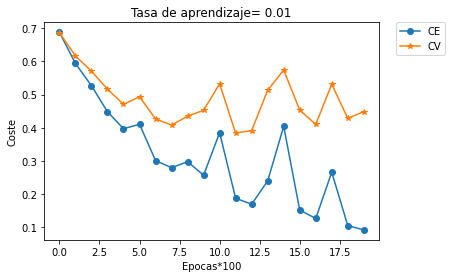

Mejor iteracion es: 935 con la semilla: 99
Número de neuronas: 3
Predv         0.0       1.0
Actualv                    
0        0.878049  0.205882
1        0.121951  0.794118
Accuracy entrenamiento: 0.9200000000000002  y accuracy validación: 0.84
Coste tras la iteración 0: 0.704780
Coste tras la iteración 1000: 0.679370


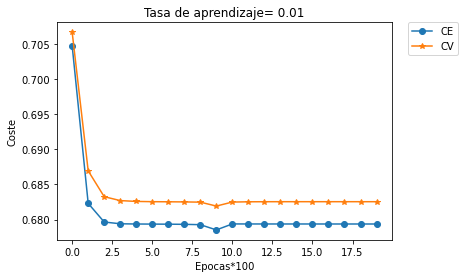

Mejor iteracion es: 915 con la semilla: 99
Número de neuronas: 4
Predv         0.0
Actualv          
0        0.573333
1        0.426667
Accuracy entrenamiento: 0.582857142857143  y accuracy validación: 0.5733333333333334
Coste tras la iteración 0: 0.771349
Coste tras la iteración 1000: 0.376313


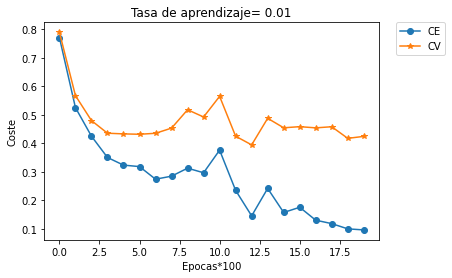

Mejor iteracion es: 880 con la semilla: 99
Número de neuronas: 5
Predv         0.0      1.0
Actualv                   
0        0.863636  0.16129
1        0.136364  0.83871
Accuracy entrenamiento: 0.9314285714285715  y accuracy validación: 0.8533333333333333
Coste tras la iteración 0: 0.753171
Coste tras la iteración 1000: 0.679391


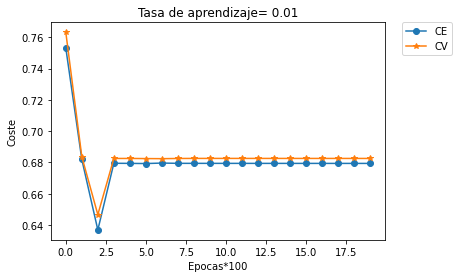

Mejor iteracion es: 588 con la semilla: 99
Número de neuronas: 6
Predv         0.0
Actualv          
0        0.573333
1        0.426667
Accuracy entrenamiento: 0.582857142857143  y accuracy validación: 0.5733333333333334
Coste tras la iteración 0: 0.723192
Coste tras la iteración 1000: 0.204849


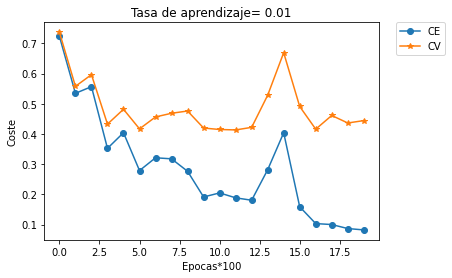

Mejor iteracion es: 879 con la semilla: 99
Número de neuronas: 7
Predv         0.0      1.0
Actualv                   
0        0.863636  0.16129
1        0.136364  0.83871
Accuracy entrenamiento: 0.9314285714285715  y accuracy validación: 0.8533333333333333
Coste tras la iteración 0: 1.193950
Coste tras la iteración 1000: 0.319200


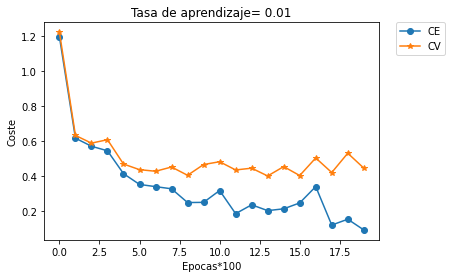

Mejor iteracion es: 990 con la semilla: 99
Número de neuronas: 8
Predv         0.0       1.0
Actualv                    
0        0.866667  0.133333
1        0.133333  0.866667
Accuracy entrenamiento: 0.9371428571428573  y accuracy validación: 0.8666666666666667
Coste tras la iteración 0: 0.698109
Coste tras la iteración 1000: 0.243173


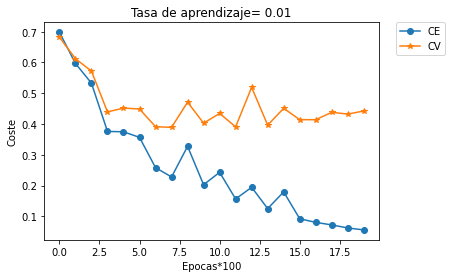

Mejor iteracion es: 870 con la semilla: 99
Número de neuronas: 9
Predv         0.0       1.0
Actualv                    
0        0.847826  0.137931
1        0.152174  0.862069
Accuracy entrenamiento: 0.9314285714285715  y accuracy validación: 0.8533333333333333
Coste tras la iteración 0: 0.682709
Coste tras la iteración 1000: 0.218144


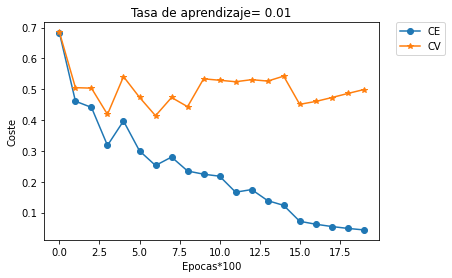

Mejor iteracion es: 530 con la semilla: 99
Número de neuronas: 10
Predv         0.0      1.0
Actualv                   
0        0.863636  0.16129
1        0.136364  0.83871
Accuracy entrenamiento: 0.9142857142857144  y accuracy validación: 0.8533333333333333
Coste tras la iteración 0: 0.767136
Coste tras la iteración 1000: 0.182418


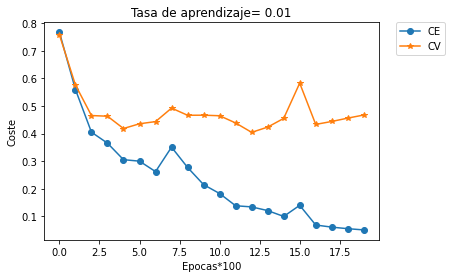

Mejor iteracion es: 805 con la semilla: 99
Número de neuronas: 11
Predv         0.0       1.0
Actualv                    
0        0.866667  0.133333
1        0.133333  0.866667
Accuracy entrenamiento: 0.9428571428571431  y accuracy validación: 0.8666666666666667
Coste tras la iteración 0: 0.979931
Coste tras la iteración 1000: 0.209514


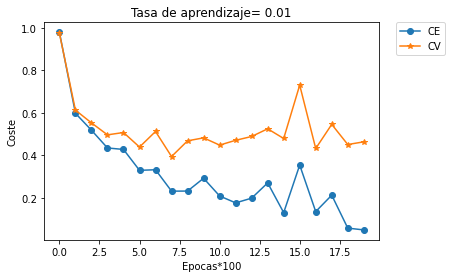

Mejor iteracion es: 1181 con la semilla: 99
Número de neuronas: 12
Predv         0.0      1.0
Actualv                   
0        0.863636  0.16129
1        0.136364  0.83871
Accuracy entrenamiento: 0.9485714285714286  y accuracy validación: 0.8533333333333333
Coste tras la iteración 0: 1.135798
Coste tras la iteración 1000: 0.229121


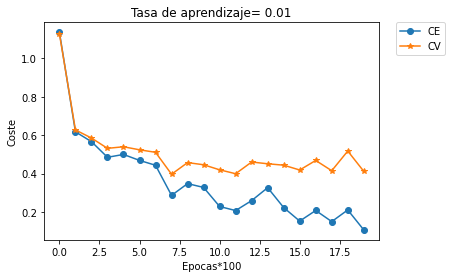

Mejor iteracion es: 968 con la semilla: 99
Número de neuronas: 13
Predv         0.0       1.0
Actualv                    
0        0.886364  0.129032
1        0.113636  0.870968
Accuracy entrenamiento: 0.9200000000000002  y accuracy validación: 0.88
Coste tras la iteración 0: 0.689247
Coste tras la iteración 1000: 0.135150


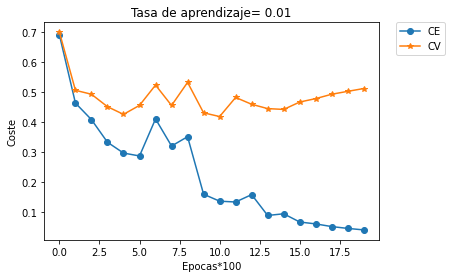

Mejor iteracion es: 525 con la semilla: 99
Número de neuronas: 14
Predv         0.0      1.0
Actualv                   
0        0.863636  0.16129
1        0.136364  0.83871
Accuracy entrenamiento: 0.92  y accuracy validación: 0.8533333333333333
Coste tras la iteración 0: 0.730311
Coste tras la iteración 1000: 0.236351


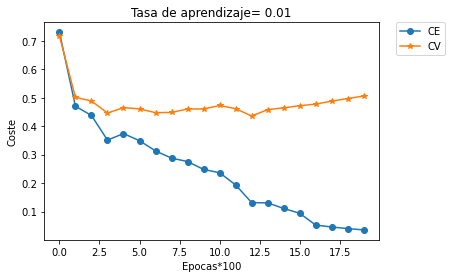

Mejor iteracion es: 306 con la semilla: 99
Número de neuronas: 15
Predv         0.0       1.0
Actualv                    
0        0.791667  0.185185
1        0.208333  0.814815
Accuracy entrenamiento: 0.8857142857142858  y accuracy validación: 0.8
Coste tras la iteración 0: 0.815812
Coste tras la iteración 1000: 0.218103


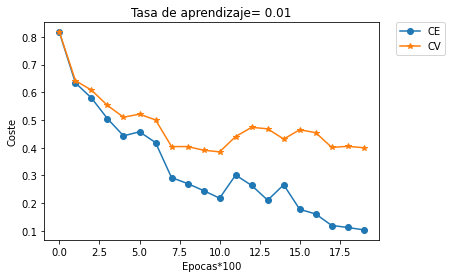

Mejor iteracion es: 1072 con la semilla: 99
Número de neuronas: 16
Predv         0.0      1.0
Actualv                   
0        0.883721  0.15625
1        0.116279  0.84375
Accuracy entrenamiento: 0.9257142857142858  y accuracy validación: 0.8666666666666667
Coste tras la iteración 0: 0.786816
Coste tras la iteración 1000: 0.233004


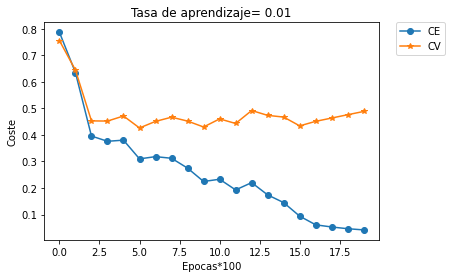

Mejor iteracion es: 348 con la semilla: 99
Número de neuronas: 17
Predv         0.0       1.0
Actualv                    
0        0.791667  0.185185
1        0.208333  0.814815
Accuracy entrenamiento: 0.8971428571428572  y accuracy validación: 0.8
Coste tras la iteración 0: 0.653950
Coste tras la iteración 1000: 0.187512


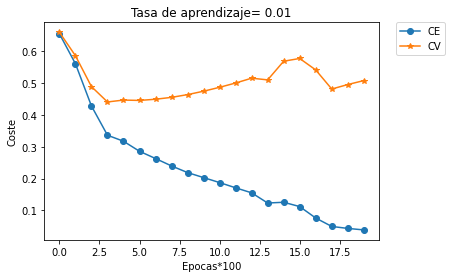

Mejor iteracion es: 264 con la semilla: 99
Número de neuronas: 18
Predv         0.0       1.0
Actualv                    
0        0.808511  0.178571
1        0.191489  0.821429
Accuracy entrenamiento: 0.8742857142857143  y accuracy validación: 0.8133333333333334
Coste tras la iteración 0: 0.788755
Coste tras la iteración 1000: 0.134873


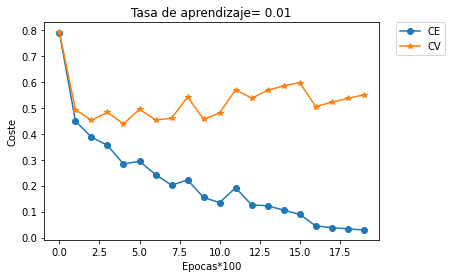

Mejor iteracion es: 431 con la semilla: 99
Número de neuronas: 19
Predv         0.0       1.0
Actualv                    
0        0.844444  0.166667
1        0.155556  0.833333
Accuracy entrenamiento: 0.9142857142857144  y accuracy validación: 0.84
Coste tras la iteración 0: 0.719333
Coste tras la iteración 1000: 0.197676


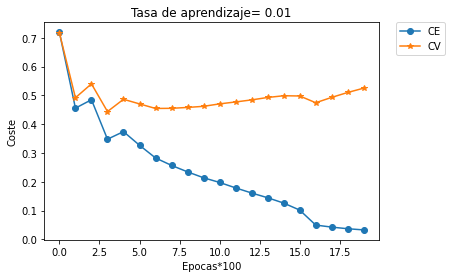

Mejor iteracion es: 332 con la semilla: 99
Número de neuronas: 20
Predv         0.0       1.0
Actualv                    
0        0.826087  0.172414
1        0.173913  0.827586
Accuracy entrenamiento: 0.9085714285714286  y accuracy validación: 0.8266666666666667
+----------+--------------------+--------------------+-------+
| NNeurons |       Acc_E        |       Acc_V        | epoca |
+----------+--------------------+--------------------+-------+
|    1     | 0.582857142857143  | 0.5733333333333334 |  1999 |
|    2     | 0.9542857142857143 | 0.8533333333333333 |  1998 |
|    3     | 0.9200000000000002 |        0.84        |  935  |
|    4     | 0.582857142857143  | 0.5733333333333334 |  915  |
|    5     | 0.9314285714285715 | 0.8533333333333333 |  880  |
|    6     | 0.582857142857143  | 0.5733333333333334 |  588  |
|    7     | 0.9314285714285715 | 0.8533333333333333 |  879  |
|    8     | 0.9371428571428573 | 0.8666666666666667 |  990  |
|    9     | 0.9314285714285715 | 0.8533333

In [88]:
x = PrettyTable(["NNeurons", "Acc_E", "Acc_V", "epoca"])

for i in range(1,21):
    param, epoc = modelo_red2(CE_x, CE_y, CV_x, CV_y, n_h = i, num_iter = 2000, tasa = 0.01, semilla = 99, print_c=True)
    # nos quedamos con el mejor numero de epocas
    param, epoc = modelo_red2(CE_x, CE_y, CV_x, CV_y, n_h = i, num_iter = (epoc+1), tasa = 0.01, semilla = 99, print_c=False)
    
    # predicciones
    pE=pred(param, CE_x)
    pV=pred(param, CV_x)
    
    # Accuracy
    # entrenamiento
    Acc_e = np.sum((pE == CE_y)/n)
    
    # validacion
    Acc_v = np.sum((pV == CV_y)/m)
    
    #matrices de confusion para train y validacion
    ye_actu = pd.Series(CE_y.ravel(), name='Actuale')
    ye_pred = pd.Series(pE.ravel(), name='Prede')
   
    df_confusione = pd.crosstab(ye_actu, ye_pred).apply(lambda r: r/r.sum(), axis=0) 
    
    yv_actu = pd.Series(CV_y.ravel(), name='Actualv')
    yv_pred = pd.Series(pV.ravel(), name='Predv')
   
    df_confusionv = pd.crosstab(yv_actu, yv_pred).apply(lambda r: r/r.sum(), axis=0) 
    
    print("Número de neuronas: " +str(i))
    print(df_confusionv)
    print("Accuracy entrenamiento: "  + str(Acc_e), " y accuracy validación: " + str(Acc_v) )
    
    x.add_row([i, Acc_e, Acc_v, epoc])
         
print(x)

#### Podemos observar que con 13 neuronas alcanzamos una exactitud de 88%, por tanto podemos determinar que la inicializacion y el ajuste de iteraciones no generó una mejora en el poder predictivo de la red.